# C.A.S.H Ship Analyzer

### Importer and Concatenater

'Pip install xxx' any missing modules from the below. I believe only 'pandas' and 'os' aren't bundled with the latest version of Python.

In [1]:
#General tools
import pandas as pd 
import numpy as np
import os

#Plotting tools
import matplotlib.pyplot as plt 
import seaborn as sbn

In [2]:
#Classification Metrics


In [77]:
#Start creation of master function
def create_shiplist():
    #Define global variables:
    all_ships = pd.DataFrame() #Generates a blank dataframe to concatenate data to.
    curr_date = pd.to_datetime('today').date() #Defines "current date" variable for use throughout function, such as export title.
    n = input('What is last # of last CSV?') #User input for number of .csvs being input. Should be the largest integer on input csvs.
    
    #Define all the mini-functions:
    #Import Xplorer CSV from data folder
    def csv_import(int): #Takes integer N from input statement above later
        df = pd.read_csv(f'./data/shiplist_{int}.csv') #generates a temporary dataframe from the csv
        return df #Passes dataframe out for manipulation
    #Concatenate imported ships
    def df_concat(all_ships, df):
        ship_df = pd.concat([all_ships, df], ignore_index=True) #concatenates temp dataframe to global all_ships df
        return ship_df
    #Add engineered column to dataframe
    def engineer_column(df):
        df['Date_Generated'] = curr_date #Creates new column 'Date_Generated' consisting of the date the query was run. 
        df['Date_Generated'] = df['Date_Generated'].astype('datetime64[ns]') #Converts default string type object to datetime object.
        return df
    #Remove spaces from column headers
    def remove_spaces(df):
        df.columns.str.replace(' ','') #EDA revealed default CSV output includes hidden spaces in headers. Removes the spaces.
        return df
    #Convert date string to datetime object
    def date_to_datetime(df):
        df[' Date'] = df[' Date'].astype('datetime64[ns]') #EDA revealed default CSV uses string object for date. Converts to datetime.
        return df
    #Convert cost column to float object
    def cost_to_float(df):
        df[' Cost'] = df[' Cost'].replace('[^.0-9]','',regex=True,inplace = False).astype(float) #Converts Cost column to float value.
        return df

    #End definition of mini-functions

    #DF generator block
    for x in range(0,int(n)): #Iterates for every .csv file in data folder.
        df = csv_import(x)
        all_ships = df_concat(all_ships, df)
    all_ships = engineer_column(all_ships)

    #Cleaner block
    all_ships = date_to_datetime(all_ships)
    all_ships = cost_to_float(all_ships)
    all_ships = remove_spaces(all_ships)
    all_ships = all_ships.sort_values('Manufacturer', ascending = True)
    all_ships = all_ships.reset_index(drop = True)
    

    #Exporter block
    if os.path.exists(f"./data/allships_history/allships_{curr_date}.csv") == True: #Check if file exists.
        overwrite_check = input ("File already exists--do you want to overwrite? (y/n)") #Prompt for overwrite confirmation
        if str.lower(overwrite_check) != 'y': #If user uses any value except y, the function will skip exporting.
            pass
        else:
            all_ships.to_csv(f"./data/allships_history/allships_{curr_date}.csv", index = False)

    return all_ships

In [78]:
allships = create_shiplist()
allships

,Manufacturer,Ship,Lti,Warbond,ID,Pledge,Cost,Date,Date_Generated
0,Aegis,Avenger Stalker,True,False,3389393,Combo - War Pack - Digital,6865.0,2014-12-22,2020-05-31
1,Aegis,Sabre Raven,False,False,16569251,Package - AEGIS Sabre Raven,0.0,2018-12-31,2020-05-31
2,Aegis,Avenger Stalker,True,False,9862620,LTI Packages - Digital Scout - LTI,65.0,2016-10-10,2020-05-31
3,Aegis,Hammerhead,True,False,13011622,Standalone Ship - Aegis Hammerhead lti,650.0,2017-11-25,2020-05-31
4,Aegis,Reclaimer,True,False,2603001,Standalone Ship - Aegis Reclaimer - LTI,350.0,2014-09-26,2020-05-31
...,...,...,...,...,...,...,...,...,...
380,Vanduul,Glaive,True,False,3388812,Combo - The Completionist - Digital,17161.0,2014-12-22,2020-05-31
381,Vanduul,Captured Vanduul Scythe,True,False,3388812,Combo - The Completionist - Digital,17161.0,2014-12-22,2020-05-31
382,Vanduul,Glaive,True,False,4892595,Standalone Ship - Vanduul Glaive,350.0,2015-08-07,2020-05-31
383,Xi'an,Khartu-al,True,False,4679792,Standalone Ship - Reliant Mini Hauler - LTI,150.0,2015-05-22,2020-05-31


## Basic Analysis

In [79]:
allships['Manufacturer'].value_counts()

Aegis           54
Anvil           53
Drake           49
Tumbril         44
Origin          41
MISC            40
RSI             31
Crusader        22
Consolidated    11
Banu             9
Aopoa            9
Argo             8
KRIG             7
Vanduul          3
Xi'an            2
Esperia          2
Name: Manufacturer, dtype: int64

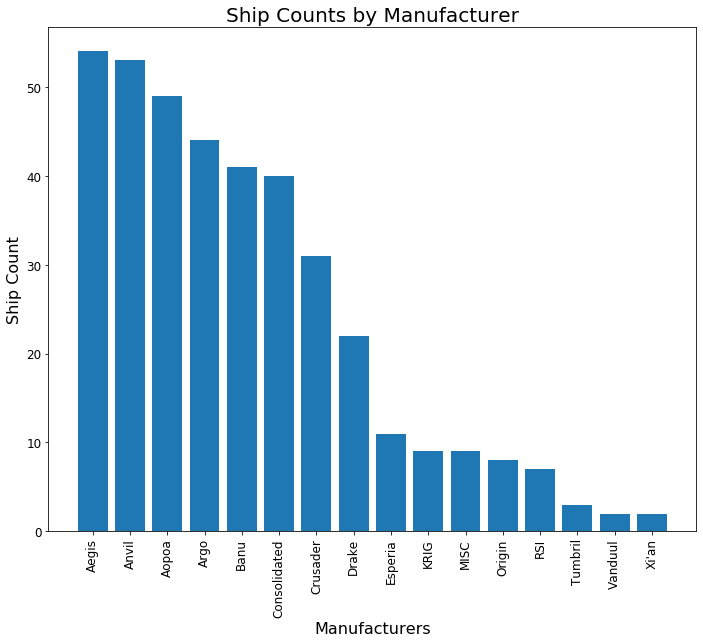

In [80]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_axes([0,0,1,1])
makers = allships['Manufacturer'].unique()
counts = allships['Manufacturer'].value_counts()
ax.bar(makers, counts)
ax.tick_params(axis = "both", labelsize = 12)
ax.set_title('Ship Counts by Manufacturer', fontsize=20)
ax.set_xlabel('Manufacturers', fontsize = 16)
ax.set_ylabel('Ship Count', fontsize = 16)
plt.xticks(rotation=90)

plt.show()


## Analysis Tools

### Total Expenditure

This tool will generate a copy of the user allships dataframe, drop all rows with duplicate package IDs, and return a DF of packages indicating LTI, Warbond, and cost. It will drop Manufacturer and Ship columns.